# Preamble

In [1]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Loading

In [2]:
file = h5py.File('0noise_gaussian_O4.h5','r')
Mcz = np.array(file['det_Mc'])
q = np.array(file['q'])
DL = np.array(file['d_L'])
file.close()

In [3]:
Nobs = len(Mcz)

# Pop Cosmo Estimation

# Toy Model II

Here $\vec{\Omega}_P = \{\mu_P, \sigma_P \}$, and $\vec{\Omega}_C = \{H_0, \Omega_M, w \}$.

Under simplified asuumptions:
1. $cov(M_{cz}^{obs}, D_L^{obs})=0$
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ is,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{q, ~D_L} \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).\Big|J \Big(\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}, q \Big)\Big|.\Big (N_{m_1 \Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}, ~q\Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{m_2 \Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}, ~q\Big )}(\mu_P, \sigma_P)\Big ).dqdD_L
$$

Now,

$$
q = \frac{m_2}{m_1}, ~M_c = \frac{(m_1m_2)^{\frac{3}{5}}}{(m_1+m_2)^{\frac{1}{5}}}
$$

This gives,

$$
m_1 = q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}M_c = q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}
$$

and,

$$
m_2 = q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}M_c = q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}
$$

Hence,

$$
\Big|J \Big(\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}, q \Big)\Big| = q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)}
$$

So the Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ becomes,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{q, ~D_L} \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).dqdD_L
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [4]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [5]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Population & Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{q, ~D_L} \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).dqdD_L
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P(D_L).\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~(q, ~D_L \sim \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i})) ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P(z(D_L, H_0, \Omega_M, w)).
\frac{dz}{dD_L}\Big |_{z(D_L, H_0, \Omega_M, w)}\\
.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~(q, ~D_L \sim \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i})) ~samples}
$$

Now $z_{nit} = \frac{z(D_L, H_0, \Omega_M, w)}{10}$, gives $P(z(D_L, H_0, \Omega_M, w)) = P(z_{unit})\frac{dz_{unit}}{dz} = P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{1}{10}$. Hence,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{1/10}{\frac{dD_L}{dz}\Big |_{z(D_L, H_0, \Omega_M, w)}}.\Big(\frac{1}{1+z(D_L, H_0, \Omega_M, w)}\Big )\\
.\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(D_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~(q, ~D_L \sim \mathcal{L}_{q, ~D_L}(q^{obs, i}, ~D_L^{obs, i})) ~samples}
$$

where,

$$
D_L = dH.(1+z).\int_0^z \frac{dz^{\prime}}{E(z^{\prime})} \Rightarrow \frac{dD_L}{dz} = \frac{D_L}{1+z} + \frac{dH.(1+z)}{E(z)} ~\Big(\text{Here}, ~dH = \frac{c}{H_0}\Big)
$$

In [6]:
wDM = 0

In [7]:
qs = q
ds = DL

print(Mcz, qs, ds)

[1.22328685 1.19709519 1.17694205 1.26313608 1.17604122 1.11290215
 1.23011214 1.32589952 1.22921232 1.13775041 1.1144669  1.18933113
 1.25425175 1.32152574 1.24297427 1.16510066 1.28342105 1.164855
 1.10302511 1.12811436 1.18851096 1.19714189 1.15931431 1.11854262
 1.1489345  1.22880782 1.1541995  1.13056687 1.17671946 1.30418739
 1.25750913 1.19500407 1.18038431 1.23700817 1.18637451 1.26932979
 1.20495223 1.21108341 1.17217294 1.13667454 1.1459404  1.17790217
 1.16852368 1.20237866 1.22979999 1.24753121 1.10632909 1.27551252
 1.11333987 1.20349908 1.23158851 1.21212524 1.23089725 1.25005441
 1.2212061  1.16716657 1.18945014 1.17269641 1.31071009 1.16227706
 1.36277154 1.17927758] [[0.77442324 0.94446934 0.84100801 ... 0.9590931  0.67215725 0.89622995]
 [0.69506955 0.83446551 0.95316386 ... 0.99716428 0.80992327 0.98222442]
 [0.7865264  0.78685938 0.80691137 ... 0.81021298 0.76035959 0.96819439]
 ...
 [0.83369093 0.94497055 0.98968037 ... 0.8929614  0.78128133 0.72739429]
 [0.7857805

In [8]:
def make_model(Mczo, qs, ds, zmax=100, Nz=1024):

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 0.7, 1.7) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.05, 0.25)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc
        
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z = at_interp(ds, dLinterp, zinterp)
        z_unit = z/10
        
        var = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit))
        ddLdz = ds/(1+z)+dH*(1+z)/Ez(z, Om, w, wDM)
        var1 = ds/(10*ddLdz)
        var2 = 1/(1+z)
        
        Mc = at.transpose(Mcz/at.transpose(1 + z))
        m1 = qs**(-0.6)*(1+qs)**0.2*Mc
        m2 = qs**0.4*(1+qs)**0.2*Mc
        
        var3 = qs**(-1.2)*(1+qs)**0.4*Mc
        var4 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), m1))
        var5 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), m2))
        
        var6 = at.sum(var*var1*var2*var3*var4*var5, axis=1)
        pm.Potential('pos', at.sum(at.log(var6)))
    return model

In [9]:
tune = 1000
target_accept = 0.99
with make_model(Mcz, qs, ds) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, sigma_P, h, Om, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9339 seconds.


In [11]:
cp = cosmo.Planck18

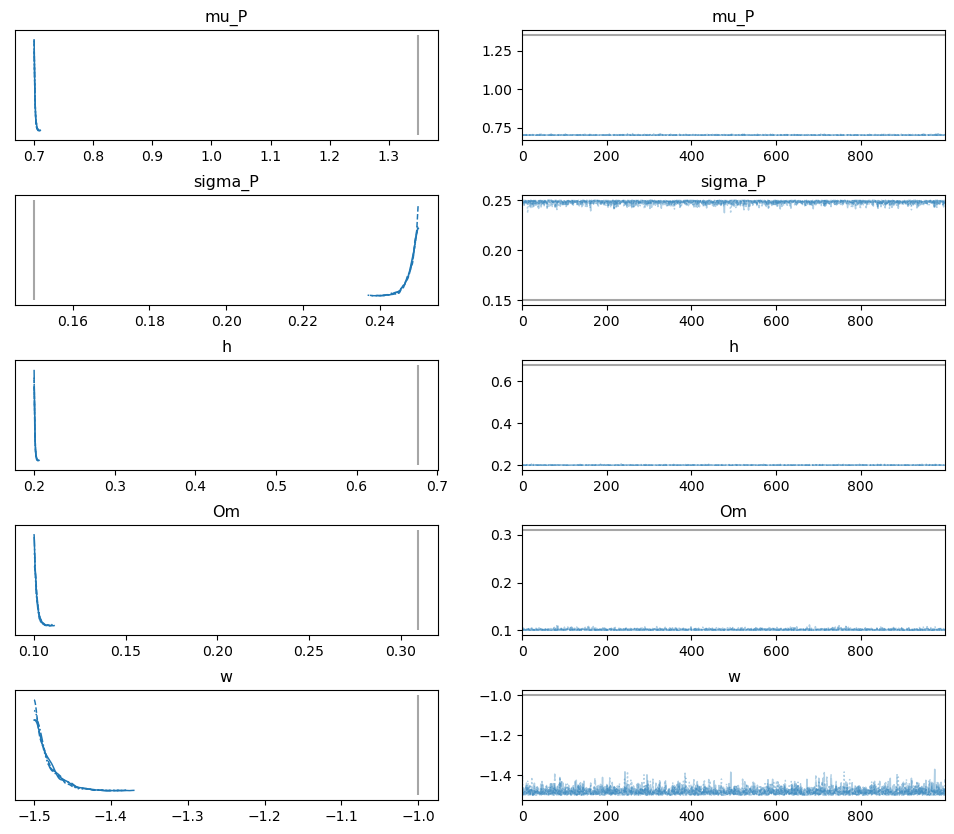

In [12]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'],
                        lines=[('mu_P', {}, 1.35),
                        ('sigma_P', {}, 0.15),
                        ('h', {}, cp.H0/100),
                        ('Om', {}, cp.Om0),
                        ('w', {}, -1)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

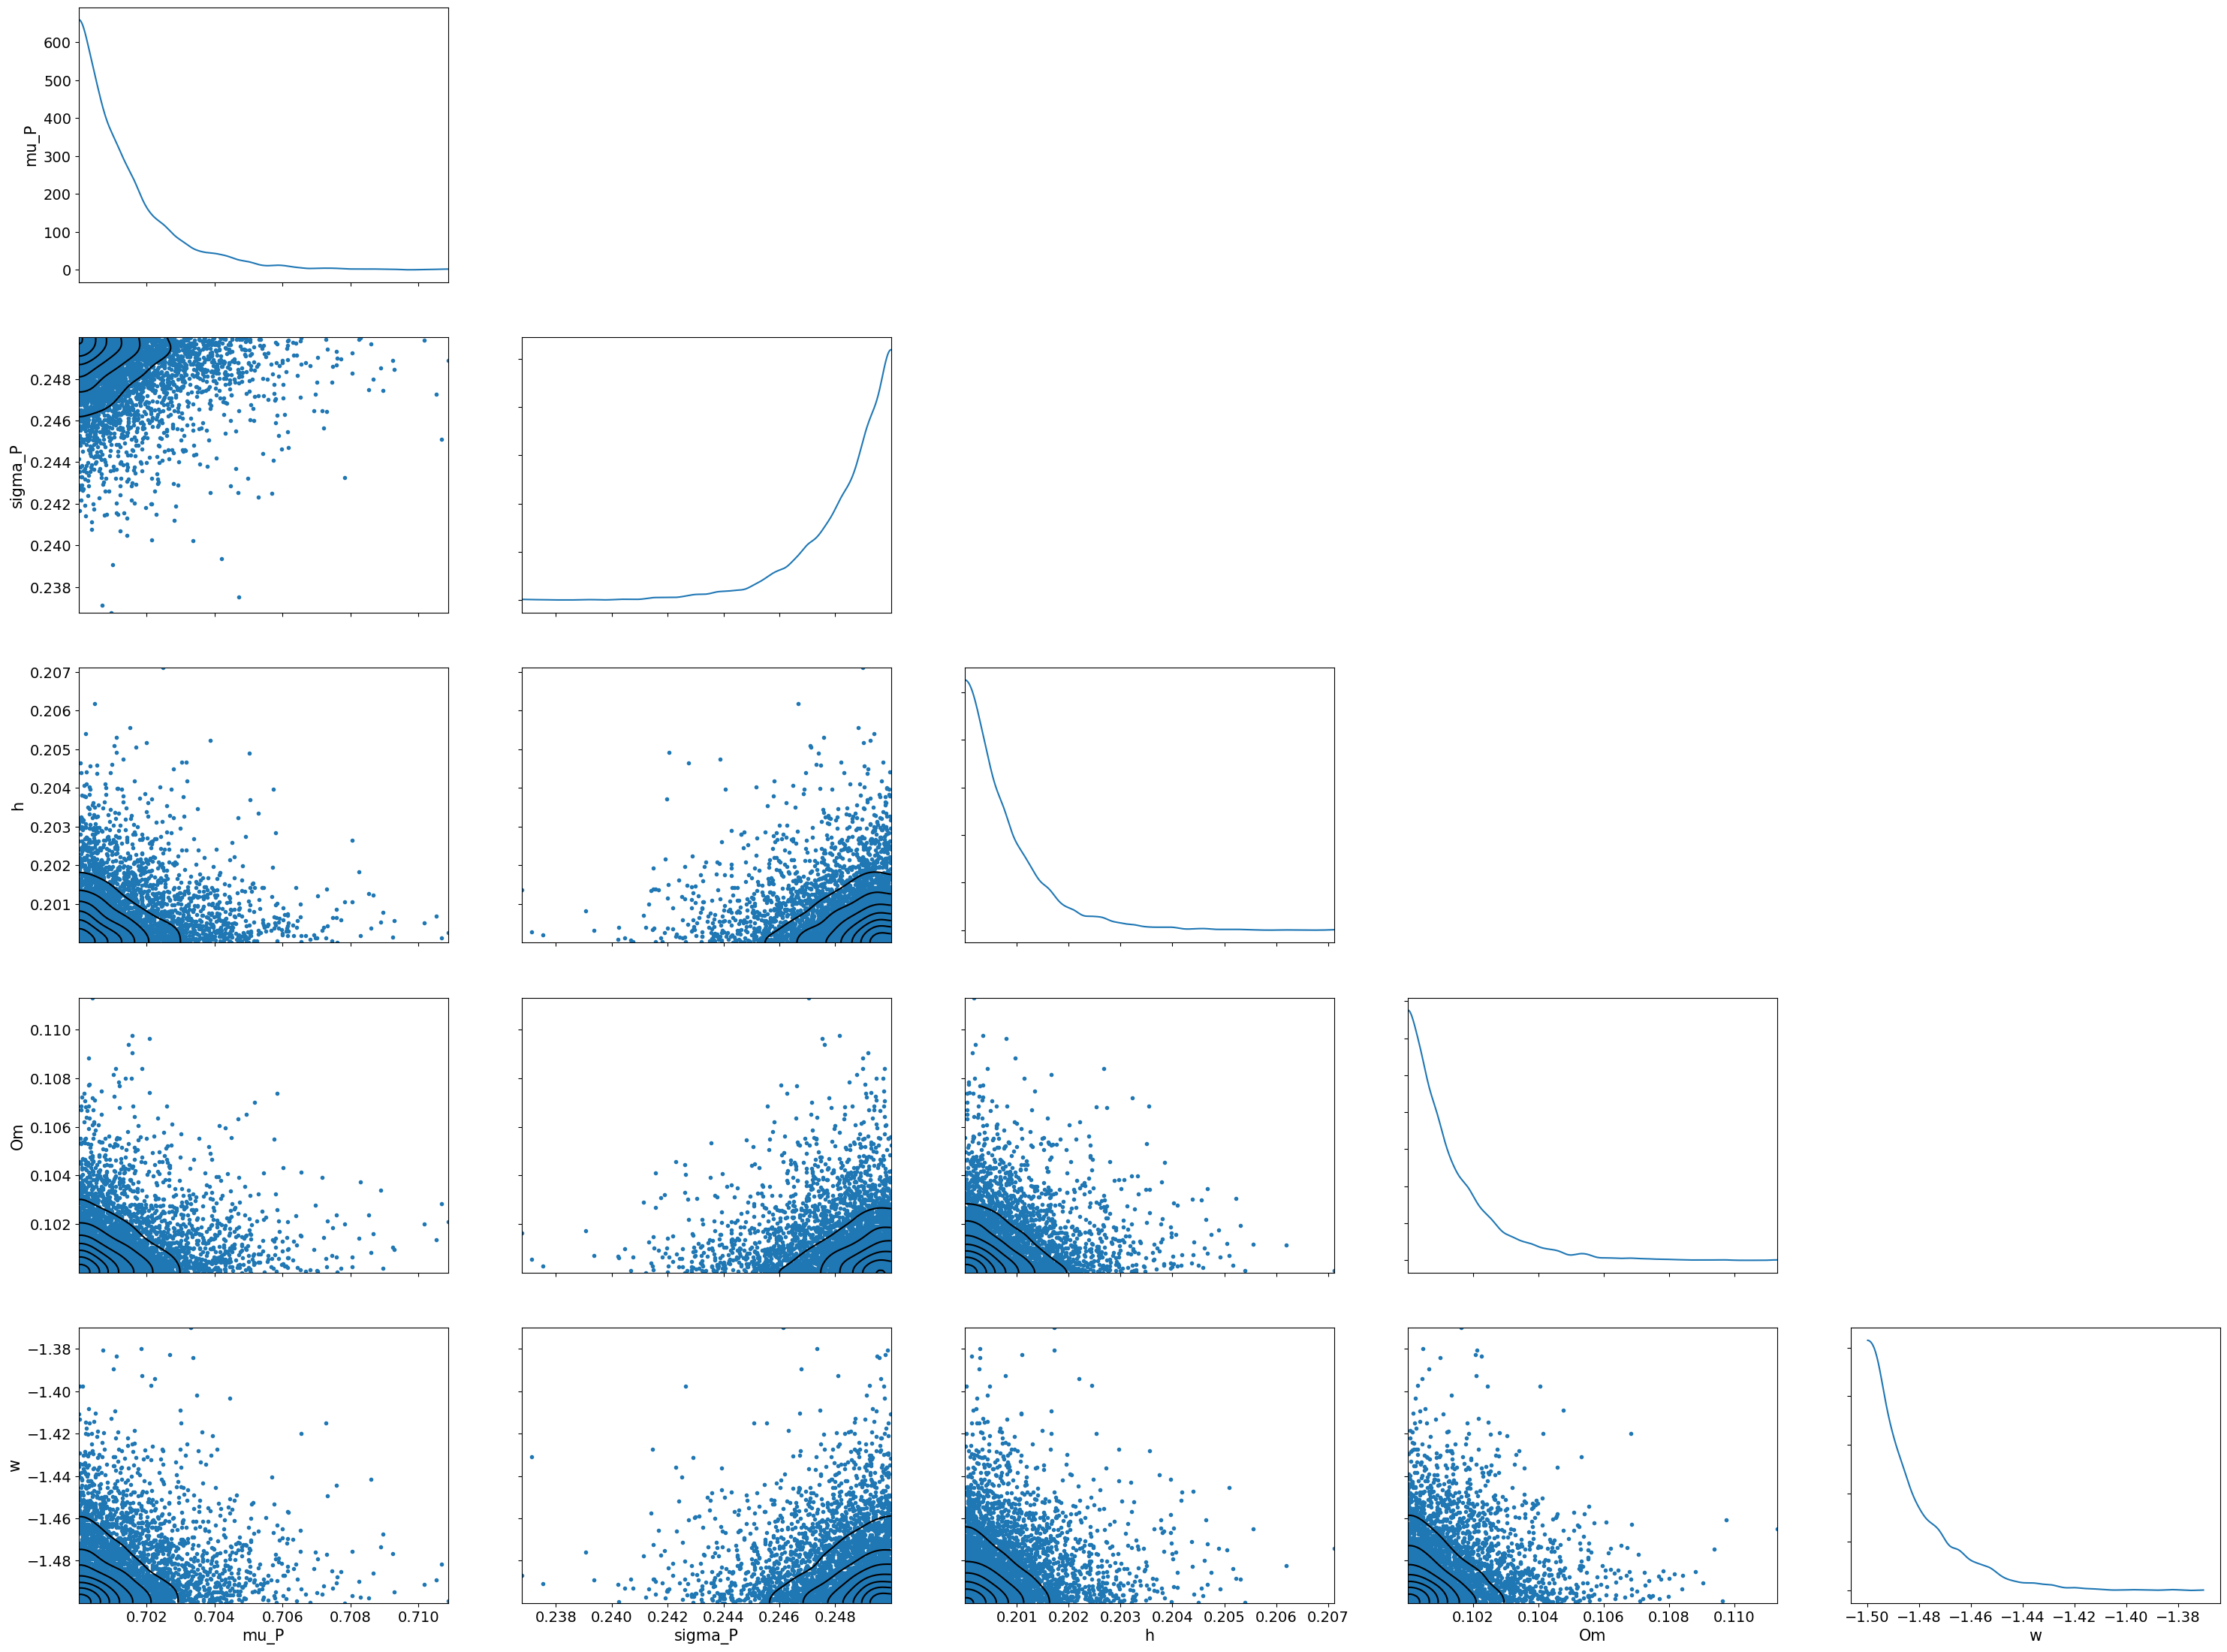

In [13]:
axes = az.plot_pair(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes.ravel()[0].figure

In [14]:
with model:
    display(az.summary(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_P,0.701,0.001,0.700,0.704,0.0,0.0,2803.0,1838.0,1.0
sigma_P,0.248,0.002,0.245,0.250,0.0,0.0,2141.0,1255.0,1.0
h,0.201,0.001,0.200,0.202,0.0,0.0,2345.0,1688.0,1.0
Om,0.101,0.001,0.100,0.104,0.0,0.0,2178.0,1623.0,1.0
w,-1.483,0.017,-1.500,-1.452,0.0,0.0,2447.0,1414.0,1.0
